# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

Mount Colab drive and extract project data

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
#import zipfile
#with zipfile.ZipFile("gdrive/My Drive/Colab Notebooks/Gesture Recognition/Collated_training/Project_data.zip","r") as zip_ref:
#    zip_ref.extractall("gdrive/My Drive/Colab Notebooks/Gesture Recognition/Collated_training/Final_data")

In [ ]:
import numpy as np
import os
#from scipy.misc import imresize
from imageio import imread
import datetime
import cv2
import matplotlib.pyplot as plt


We set the random seed so that the results don't vary drastically.

In [ ]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [ ]:
train_doc = np.random.permutation(open('gdrive/My Drive/Colab Notebooks/Gesture Recognition/Collated_training/Final_data/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('gdrive/My Drive/Colab Notebooks/Gesture Recognition/Collated_training/Final_data/Project_data/val.csv').readlines())
batch_size = 32 #experiment with the batch size

(360, 360, 3)


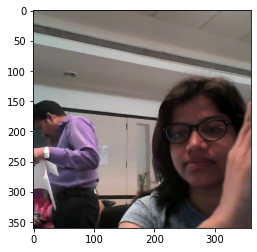

In [ ]:
# Read one random image and check it's shape
img = imread('gdrive/My Drive/Colab Notebooks/Gesture Recognition/Collated_training/Final_data/Project_data/train/WIN_20180907_15_35_09_Pro_Right Swipe_new/WIN_20180907_15_35_09_Pro_00012.png')
print(img.shape)
plt.imshow(img)

(128, 128, 3)


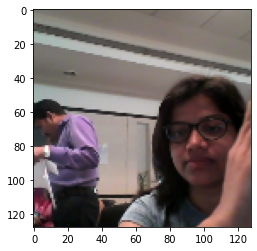

In [ ]:
img = cv2.resize(img, (128,128))
print(img.shape)
plt.imshow(img)

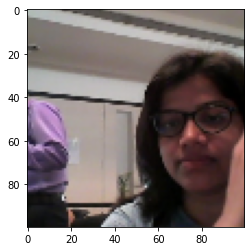

In [ ]:
def centerCrop(img, width, height):
    h = 20
    w = 20
    cimg = img[h:h+height, w:w+width]
    return cimg

cimg = centerCrop(img, 100, 100)
plt.imshow(cimg)

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [ ]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [0,6,10] #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(t)//batch_size # calculate the number of batches
        #print("num_batches :: "+ str(num_batches))
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,3,100,100,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            #print("batch :: "+ str(batch))
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    #print("1 ::::: ")
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    image = cv2.resize(image, (128,128))
                    image = centerCrop(image, 100, 100)

                    
                    batch_data[folder,idx,:,:,0] = (image[:,:,0] - np.min(image[:,:,0] ))/(np.max(image[:,:,0] ) - np.min(image[:,:,0] ))#normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (image[:,:,1] - np.min(image[:,:,1] ))/(np.max(image[:,:,1] ) - np.min(image[:,:,1] ))#normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (image[:,:,2] - np.min(image[:,:,2] ))/(np.max(image[:,:,2] ) - np.min(image[:,:,2] ))#normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        #print("num_batches*batch_size ::: "+ str((num_batches*batch_size)))
        #print("len(t) ::: "+ str(len(t)))
        folder = 0
        if((num_batches*batch_size) < len(t)):
          rem_batches = len(t) - (num_batches*batch_size)
          for rem_batch in range((num_batches*batch_size), len(t)):
            batch_data = np.zeros((rem_batches,3,100,100,3))
            batch_labels = np.zeros((rem_batches,5))
            #print("2 :::::: ")
            imgs = os.listdir(source_path+'/'+ t[rem_batch].split(';')[0]) # read all the images in the folder
            for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                image = imread(source_path+'/'+ t[rem_batch].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                image = cv2.resize(image, (128,128))
                image = centerCrop(image, 100, 100)
                batch_data[folder,idx,:,:,0] = (image[:,:,0] - np.min(image[:,:,0] ))/(np.max(image[:,:,0] ) - np.min(image[:,:,0] ))#normalise and feed in the image
                batch_data[folder,idx,:,:,1] = (image[:,:,1] - np.min(image[:,:,1] ))/(np.max(image[:,:,1] ) - np.min(image[:,:,1] ))#normalise and feed in the image
                batch_data[folder,idx,:,:,2] = (image[:,:,2] - np.min(image[:,:,2] ))/(np.max(image[:,:,2] ) - np.min(image[:,:,2] ))#normalise and feed in the image
            batch_labels[folder, int(t[rem_batch].strip().split(';')[2])] = 1
            folder = folder+1
          yield batch_data, batch_labels


Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [ ]:
curr_dt_time = datetime.datetime.now()
train_path = 'gdrive/My Drive/Colab Notebooks/Gesture Recognition/Collated_training/Final_data/Project_data/train'
val_path = 'gdrive/My Drive/Colab Notebooks/Gesture Recognition/Collated_training/Final_data/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 100 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 100


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [ ]:
from tensorflow import keras
from keras import layers
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Rescaling, Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

In [ ]:
model = Sequential()
model.add(Conv3D(filters= 32, kernel_size=3, padding='same', strides=3))
model.add(Activation('relu'))
model.add(BatchNormalization())
#model.add(Conv3D(32, 3))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=1))
model.add(Dropout(0.25))

model.add(Conv3D(64, 3, padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
#model.add(Conv3D(64, 3))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=1))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(5))
model.add(Activation('softmax'))

In [ ]:
#model = get_model(width=100, height=100, depth=64)
#model.summary()

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [ ]:
initial_learning_rate = 0.001
#lr_schedule = keras.optimizers.schedules.ExponentialDecay(
#    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
#)

optimiser = keras.optimizers.Adam(learning_rate=initial_learning_rate) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])


In [ ]:
model.build((batch_size,3,100,100,3))
print (model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_2 (Conv3D)           (32, 1, 34, 34, 32)       2624      
                                                                 
 activation_6 (Activation)   (32, 1, 34, 34, 32)       0         
                                                                 
 batch_normalization_4 (Batc  (32, 1, 34, 34, 32)      128       
 hNormalization)                                                 
                                                                 
 activation_7 (Activation)   (32, 1, 34, 34, 32)       0         
                                                                 
 batch_normalization_5 (Batc  (32, 1, 34, 34, 32)      128       
 hNormalization)                                                 
                                                                 
 max_pooling3d_2 (MaxPooling  (32, 1, 34, 34, 32)     

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [ ]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [ ]:
model_name = 'gdrive/My Drive/Colab Notebooks/Gesture Recognition/' + 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [ ]:
#from tensorflow.compat.v1 import ConfigProto
#from tensorflow.compat.v1 import InteractiveSession

#config = ConfigProto()
#config.gpu_options.allow_growth = True
#session = InteractiveSession(config=config)

In [ ]:
model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  gdrive/My Drive/Colab Notebooks/Gesture Recognition/Collated_training/Final_data/Project_data/train ; batch size = 32


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/100
21/21 [==============================] - ETA: 0s - loss: 10.6275 - categorical_accuracy: 0.3514Source path =  gdrive/My Drive/Colab Notebooks/Gesture Recognition/Collated_training/Final_data/Project_data/val ; batch size = 32

Epoch 1: saving model to gdrive/My Drive/Colab Notebooks/Gesture Recognition/model_init_2022-09-0906_49_13.619049/model-00001-10.62745-0.35143-1.99707-0.21000.h5
21/21 [==============================] - 16s 753ms/step - loss: 10.6275 - categorical_accuracy: 0.3514 - val_loss: 1.9971 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/100
21/21 [==============================] - ETA: 0s - loss: 1.6648 - categorical_accuracy: 0.5973
Epoch 2: saving model to gdrive/My Drive/Colab Notebooks/Gesture Recognition/model_init_2022-09-0906_49_13.619049/model-00002-1.66481-0.59729-2.83159-0.24000.h5
21/21 [==============================] - 17s 829ms/step - loss: 1.6648 - categorical_accuracy: 0.5973 - val_loss: 2.8316 - val_categorical_accuracy: 0.2400 - lr:

## Model# 2 using Resnet
Tried building another model with Resnet, but the sample code I got from previous modules was not working. So decided to leave it for now, will try again later.

In [ ]:
#import resnet
from keras.applications import resnet
from tensorflow.keras import optimizers

In [ ]:
sgd = optimizers.SGD()
img_channels = 3
img_rows = 100
img_cols = 100
nb_classes = 5
model = resnet.ResnetBuilder.build_resnet_18((img_channels, img_rows, img_cols), nb_classes)
model.compile(loss='categorical_crossentropy',optimizer= sgd,
              metrics=['accuracy'])


AttributeError: ignored

In [ ]:
model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)